In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
#import matplotlib.animation as animation
#from IPython.display import HTML

In [2]:
os.chdir('/home/samy/Desktop/old_multi_gan-master/notebook_samy')

In [3]:
from data import make_8gmm, infinite_iter
from synthetic import GeneratorSynthetic, DiscriminatorSynthetic
from losses import compute_gan_loss

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


### Experiment

In [5]:
dataset, sampler = make_8gmm()

In [6]:
batch_size = 512
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
dataset.tensors = tuple(tensor.to(device) for tensor in dataset.tensors)

In [8]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader = infinite_iter(data_loader)
fixed_data = next(data_loader)[0].to('cpu')

In [18]:
len(list(data_loader))

KeyboardInterrupt: 

In [9]:
depth = 3

ndf = 512
ngf = 512
noise_dim = 32


loss_type = 'wgan'
num_epochs = 1

In [10]:
netG = GeneratorSynthetic(depth=depth, n_filters=ngf, batch_norm=True).to(device)
netD = DiscriminatorSynthetic(depth=depth, n_filters=ndf, batch_norm=False).to(device)

In [11]:
# Setup Adam optimizers for both G and D
D_lr = 1e-3
G_lr = 1e-4
beta1 = 0.
beta2 = 0.999
optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=(beta1, beta2))

In [12]:


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=(beta1, 0.999))

In [13]:
log_weights = {'G': torch.full((1,), fill_value=-math.log(1), device=device),
                   'D': torch.full((1,), fill_value=-math.log(1), device=device)}


losses = {'G': torch.zeros((1), device=device),
              'D': torch.zeros((1), device=device)}
counts = {'G': torch.zeros((1), device=device),
          'D': torch.zeros((1), device=device)}
last_losses = {'G': None, 'D': None}
true_loglike = sampler.log_prob(fixed_data).mean().item()

In [16]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):

        ############################
        # (1) Update D network:
        ###########################
        
        netD.zero_grad()

        true_data = next(data_loader)[0].to(device)
        
        true_logits = netD(true_data)
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_data = netG(noise)
        
        fake_logits = netD(fake_data)  # the coupling term
        loss = compute_gan_loss(true_logits=true_logits,
                                         fake_logits=fake_logits,
                                         loss_type=loss_type)
        
        
        loss['D'].backward(retain_graph=True)
        
        optimizerD.step()
        
         ############################
        # (2) Update G network:
        ###########################
        
        
        true_logits = netD(true_data)
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_data = netG(noise)
        
        fake_logits = netD(fake_data)  # the coupling term
        loss = compute_gan_loss(true_logits=true_logits,
                                         fake_logits=fake_logits,
                                         loss_type=loss_type)
        
        

        loss['G'].backward(retain_graph=True)

        
        optimizerG.step()
        
        
        if loss_type == 'wgan':
            for p in netD.parameters():
                p.data.clamp_(-5, 5)
        
 
        
   
    
    
    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
              % (epoch, num_epochs,  
                 loss['D'].item(), loss['G'].item()))

    # Save Losses for plotting later
    G_losses.append(losses['G'].item())
    D_losses.append(losses['D'].item())
 

Starting Training Loop...


KeyboardInterrupt: 

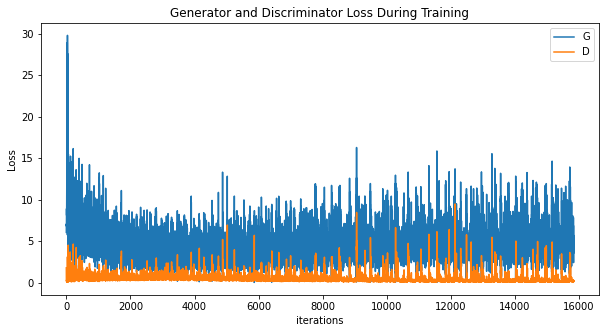

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()